# TRAINING 

## Libraries

In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

## DATA PROCESSING


In [4]:
file_path = "Data/train.csv"
df = pd.read_csv(file_path)

indices_toxic = df.index[df["class"] == 1].tolist()
indices_non_toxic = df.index[df["class"] == 0].tolist()
print("molecula toxic : ",len(indices_toxic))
print("molecula non toxic : ",len(indices_non_toxic))

names = df['smiles']
X = df.drop(columns=["smiles","class"])
y = df["class"]

# Split train/test
X_train, X_test, y_train, y_test, names_train, names_test = train_test_split(
    X, y, names, stratify=y, test_size=0.2, random_state=42
)


molecula toxic :  4816
molecula non toxic :  4599


# RANDOM FOREST

## Testing parameters

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from joblib import parallel_backend
import pandas as pd
from sklearn.metrics import make_scorer, cohen_kappa_score

kappa_scorer = make_scorer(cohen_kappa_score)

param_grid = {
    'n_estimators': [300], 
    'max_depth': [30],
    'min_samples_split': [5],
    'min_samples_leaf': [1],
    'max_features': ['sqrt']
}

print("Nombre de combinaisons à tester :", len(list(ParameterGrid(param_grid))))

with parallel_backend('loky'):
    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42, n_jobs=4),
        param_grid,
        cv=2,
        scoring=kappa_scorer,  # Kappa score
        n_jobs=4,
        verbose=2
    )
    grid_search.fit(X_train, y_train)

print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur score de validation croisée (kappa) :", grid_search.best_score_)

results = pd.DataFrame(grid_search.cv_results_)
# Affichage complet des colonnes et largeur max
pd.set_option('display.max_colwidth', None)
display(results[['params', 'mean_test_score', 'std_test_score']].sort_values(by='mean_test_score', ascending=False))



Nombre de combinaisons à tester : 1
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Meilleurs paramètres : {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Meilleur score de validation croisée (kappa) : 0.5923593701441507


,params,mean_test_score,std_test_score
0,"{'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}",0.592359,0.002169


## Affichage de l'arbre

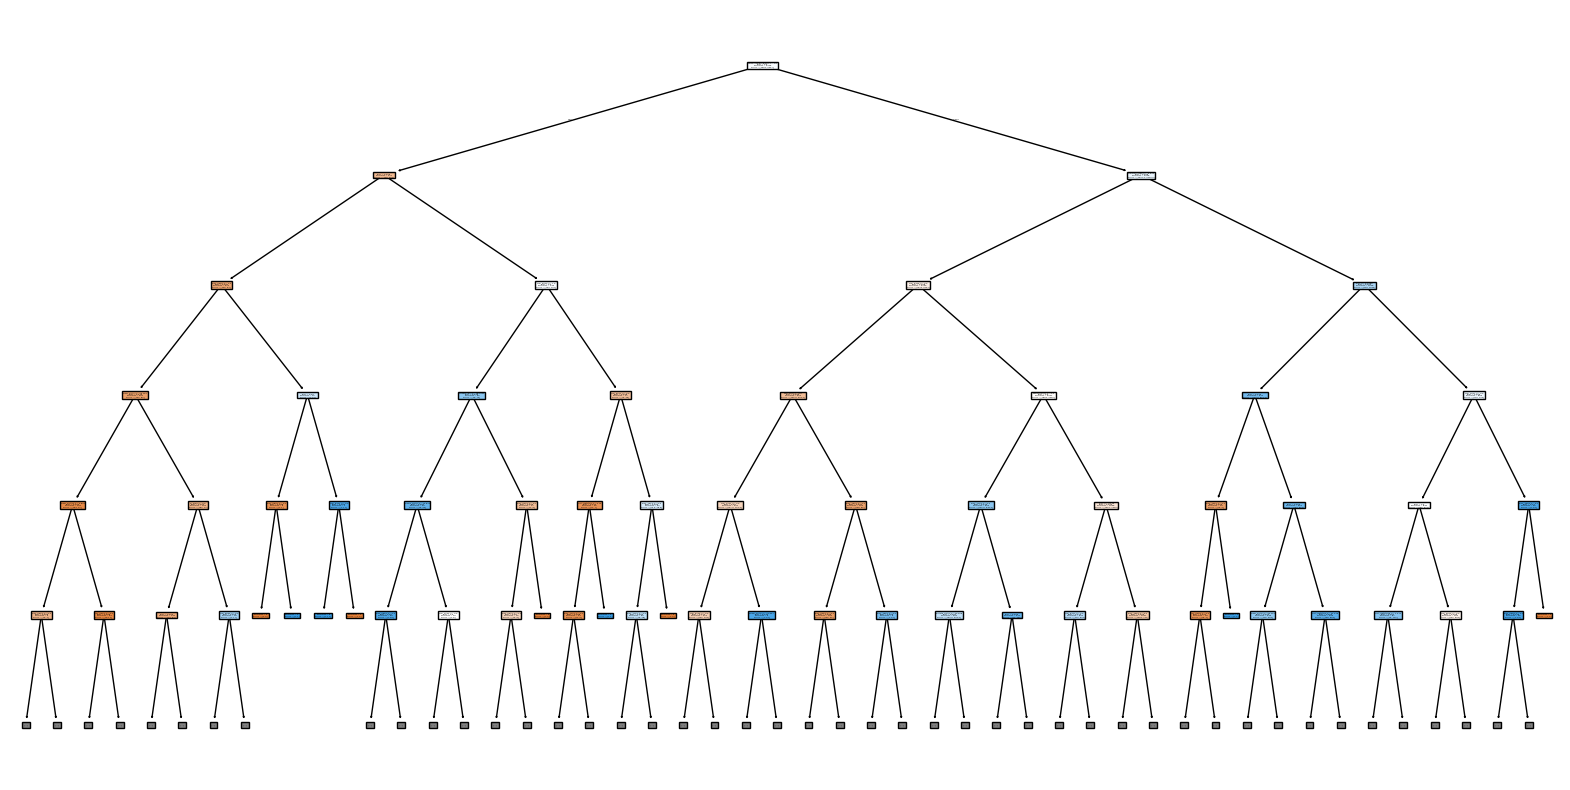

In [7]:
from sklearn.tree import plot_tree, export_text
import matplotlib.pyplot as plt

# Extraire le premier arbre de la forêt entraînée
estimator = grid_search.best_estimator_.estimators_[0]

# Affichage graphique de l'arbre
plt.figure(figsize=(20, 10))
plot_tree(estimator, feature_names=X_train.columns, filled=True, max_depth=5)  # max_depth=3 pour lisibilité
plt.show()

# PDF

plt.figure(figsize=(20, 10))
plot_tree(estimator, feature_names=X_train.columns, filled=True, max_depth=5)
plt.tight_layout()
plt.savefig("arbre_random_forest.pdf")  # <-- Export en PDF
plt.close()

## Training the best RANDOM FOREST

In [8]:
# Entraînement du modèle Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=30,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features='sqrt',
    criterion='entropy',      # ou 'gini'
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)

# Prédictions
y_pred = rf_clf.predict(X_test)

KeyboardInterrupt: 

## Printing results

In [ ]:
# Évaluation
print("📊 Classification report (Random Forest):\n")
print(classification_report(y_test, y_pred))
print(f"🎯 AUC score (Random Forest): {roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:, 1]):.4f}")

from sklearn.metrics import cohen_kappa_score
print("Kappa score:", cohen_kappa_score(y_test, y_pred))

correct = (y_pred == y_test).sum()
total = len(y_test)
print(f"Nombre de bonnes prédictions : {correct/total:.3%}")

## Cross validation 

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, cohen_kappa_score

kappa_scorer = make_scorer(cohen_kappa_score)

scores = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring= kappa_scorer)

print("Scores de validation croisée :", scores)
print("Score moyen :", scores.mean())

# Entrainement ROBUSTE

## Information mutuelle

In [ ]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import matplotlib.pyplot as plt

nb_features = 250

# Calcul de l'information mutuelle pour chaque feature
mi = mutual_info_classif(X_train, y_train, random_state=42)

# Récupérer les indices des 250 features les plus informatives
indices = mi.argsort()[-nb_features:][::-1]
top_features_mutual = X_train.columns[indices]

plt.figure(figsize=(8, 5))
plt.barh(top_features_mutual, mi[indices])
plt.xlabel("Mutual Information")
plt.title(f"Top {nb_features} features (Mutual Information)")
plt.gca().invert_yaxis()
plt.show()

## Nouvel entraînement avec seulement les meilleures features de l'info mutuelle

In [ ]:
# Nouveau jeu de données réduit
X_train_reduced = X_train[top_features_mutual]
X_test_reduced = X_test[top_features_mutual]

# Entraînement du modèle Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=5,
    max_features='sqrt',
    criterion='gini',      
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train_reduced, y_train)

# Prédictions
y_pred = rf_clf.predict(X_test_reduced)

# Évaluation
print("📊 Classification report (Random Forest):\n")
print(classification_report(y_test, y_pred))
print(f"🎯 AUC score (Random Forest): {roc_auc_score(y_test, rf_clf.predict_proba(X_test_reduced)[:, 1]):.4f}")

from sklearn.metrics import cohen_kappa_score
print("Kappa score:", cohen_kappa_score(y_test, y_pred))

correct = (y_pred == y_test).sum()
total = len(y_test)
print(f"Nombre de bonnes prédictions : {correct/total:.3%}")

## Important features after the 1st training on Random Forest

In [ ]:
nb_features = 100

importances = rf_clf.feature_importances_
indices = importances.argsort()[-nb_features:][::-1]
top_features_rf = X_train.columns[indices]

plt.figure(figsize=(8, 5))
plt.barh(top_features_rf, importances[indices])
plt.xlabel("Importance")
plt.title(f"Top {nb_features} features (Random Forest)")
plt.gca().invert_yaxis()
plt.show()

print(top_features_rf)


## Nouvel entrainement sur les meilleures features après 1st entrainement sur random forest

In [ ]:
# Sélectionne les colonnes importantes dans X_train et X_test
X_train_top = X_train[top_features_rf]
X_test_top = X_test[top_features_rf]

# Nouveau modèle Random Forest entraîné sur ces features
rf_clf_top = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=12,
    max_features='sqrt',
    criterion='entropy',
    random_state=42,
    n_jobs=-1
)
rf_clf_top.fit(X_train_top, y_train)

# Prédictions et évaluation
y_pred_top = rf_clf_top.predict(X_test_top)
print(classification_report(y_test, y_pred_top))
print(f"AUC score: {roc_auc_score(y_test, rf_clf_top.predict_proba(X_test_top)[:, 1]):.4f}")

## Printing results

In [ ]:
# Évaluation sur les top features
print("📊 Classification report (Random Forest):\n")
print(classification_report(y_test, y_pred_top))
print(f"🎯 AUC score (Random Forest): {roc_auc_score(y_test, rf_clf_top.predict_proba(X_test_top)[:, 1]):.4f}")

from sklearn.metrics import cohen_kappa_score
print("Kappa score:", cohen_kappa_score(y_test, y_pred_top))

correct = (y_pred_top == y_test).sum()
total = len(y_test)
print(f"Nombre de bonnes prédictions : {correct/total:.3%}")

## Cross validation 

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, cohen_kappa_score

# Kappa score
kappa_scorer = make_scorer(cohen_kappa_score)
scores_kappa = cross_val_score(
    rf_clf_top,
    X_train_top,
    y_train,
    cv=5,
    scoring=kappa_scorer
)
print("Scores de validation croisée (Kappa) :", scores_kappa)
print("Score moyen (Kappa) :", scores_kappa.mean())

# Accuracy
scores_acc = cross_val_score(
    rf_clf_top,
    X_train_top,
    y_train,
    cv=5,
    scoring='accuracy'
)
print("Scores de validation croisée (Accuracy) :", scores_acc)
print("Score moyen (Accuracy) :", scores_acc.mean())

## Affichage de l'arbre 

In [ ]:
from sklearn.tree import plot_tree, export_text
import matplotlib.pyplot as plt

# Extraire le premier arbre de la forêt entraînée sur les top features
estimator = rf_clf_top.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(estimator, feature_names=X_train_top.columns, filled=True, max_depth=15)
plt.show()

plt.figure(figsize=(20, 10))
plot_tree(estimator, feature_names=X_train_top.columns, filled=True, max_depth=15)
plt.tight_layout()
plt.savefig("arbre_random_forest_top.pdf")
plt.close()

## Evaluation de l'overfitting

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

# Prédictions sur le train
y_pred_train = rf_clf_top.predict(X_train_top)
print("=== Résultats sur le TRAIN ===")
print(classification_report(y_train, y_pred_train))
print(f"AUC train : {roc_auc_score(y_train, rf_clf_top.predict_proba(X_train_top)[:, 1]):.4f}")

# Prédictions sur le test
y_pred_test = rf_clf_top.predict(X_test_top)
print("=== Résultats sur le TEST ===")
print(classification_report(y_test, y_pred_test))
print(f"AUC test : {roc_auc_score(y_test, rf_clf_top.predict_proba(X_test_top)[:, 1]):.4f}")

## Test du modèle sur test_1.csv

In [ ]:
import pandas as pd

# Charger le nouveau jeu de test
df_test = pd.read_csv("Data/test_1.csv")

# Garder l'identifiant smiles si présent
if 'smiles' in df_test.columns:
    smiles = df_test['smiles']
    X_test_new = df_test.drop(columns=['smiles'])
else:
    smiles = None
    X_test_new = df_test

# Sélectionner les top features
X_test_new_top = X_test_new[top_features_rf]

# Prédictions
y_pred_new = rf_clf_top.predict(X_test_new_top)

# Création du DataFrame de résultats (smiles + prediction)
results = pd.DataFrame({
    'smiles': smiles if smiles is not None else range(len(y_pred_new)),
    'prediction': y_pred_new
})

# Sauvegarde dans un CSV
results.to_csv("Data/resultats_test_1.csv", index=False)
print("Résultats sauvegardés dans resultats_test_1.csv")

## Correspondance entre mon algo sur test1 et les algos de l'Etienne 

In [ ]:
import pandas as pd

df_moi = pd.read_csv("Data/resultats_test_1.csv")
df_etienne = pd.read_csv("Data/pred_1.csv")

# Merge sur 'smiles'
df_merged = pd.merge(df_moi, df_etienne, on='smiles')

# Compare 'prediction' (toi) et 'class' (Etienne)
identiques = (df_merged['prediction'] == df_merged['class']).sum()
total = len(df_merged)
print(f"Nombre de classes identiques : {identiques} / {total} ({identiques/total:.2%})")